# [Cookbook: LangGraph Integration](https://langfuse.com/docs/integrations/langchain/example-python-langgraph)

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Create Agent

In [3]:
from typing import Annotated
 
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
 
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
 
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
 
graph_builder = StateGraph(State)
 
llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)
 
# The chatbot node function takes the current State as input and returns an updated messages list. This is the basic pattern for all LangGraph node functions.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
 
# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
graph_builder.add_node("chatbot", chatbot)
 
# Add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.set_entry_point("chatbot")
 
# Set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.set_finish_point("chatbot")
 
# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

### Add Langfuse as callback to the invocation

In [4]:
from langfuse.callback import CallbackHandler
 
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()
 
for s in graph.stream({"messages": [HumanMessage(content = "What is Langfuse?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='Langfuse is a platform designed to help developers and companies monitor, debug, and improve their AI applications, particularly those that involve natural language processing (NLP) and large language models (LLMs). It provides tools for tracking the performance of AI models, analyzing user interactions, and identifying areas for improvement. By offering insights into how AI models are being used and where they might be falling short, Langfuse aims to enhance the reliability and effectiveness of AI-driven applications.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 13, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_r

### Use Langfuse with LangGraph Server

In [7]:
from typing import Annotated
 
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
 
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
 
from langfuse.callback import CallbackHandler
 
class State(TypedDict):
  messages: Annotated[list, add_messages]
 
graph_builder = StateGraph(State)
 
llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)
 
def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}
 
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
 
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()
 
# Call "with_config" from the compiled graph.
# It returns a "CompiledGraph", similar to "compile", but with callbacks included.
# This enables automatic graph tracing without needing to add callbacks manually every time.
graph = graph_builder.compile().with_config({"callbacks": [langfuse_handler], "run_name": "chatbot_202503"})

In [8]:
graph.invoke({"messages": [HumanMessage(content = "What is ALH840001?")]})

{'messages': [HumanMessage(content='What is ALH840001?', additional_kwargs={}, response_metadata={}, id='fb87741a-4d46-4128-a401-1a0ffd75336d'),
  AIMessage(content='ALH84001 is a meteorite that was discovered in the Allan Hills region of Antarctica in 1984. It is a part of a group of meteorites known as SNC meteorites, which are believed to have originated from Mars. ALH84001 gained significant attention in 1996 when a team of scientists led by NASA announced that they had found possible evidence of ancient microbial life within the meteorite. This evidence included structures that resembled fossilized bacteria, as well as certain mineral and chemical features that could be associated with biological activity.\n\nThe claim sparked widespread interest and debate within the scientific community and the public. However, subsequent research has provided alternative, non-biological explanations for the features observed in ALH84001, and the consensus remains that there is no definitive evi

## Example 2: Multi agent application with LangGraph

In [9]:
from typing import Annotated
 
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool
 
# Define a tools that searches Wikipedia
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
 
# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

In [10]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain.chains.base import Chain

In [11]:
def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list) -> Chain:
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [12]:
def agent_node(state, agent: Chain, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]} # 把 agent 的输出作为人类消息返回

In [13]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from typing import Literal

In [14]:
members = ["Researcher", "CurrentTime"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "{format_instructions}"
)

# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

class RouteSchema(BaseModel):
    next: Literal[*options] = Field(..., description="Next step") # type: ignore

parser = JsonOutputParser(pydantic_object=RouteSchema)

# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members), format_instructions=parser.get_format_instructions())

llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = prompt | llm | parser



In [15]:
import functools
import operator
from typing import Sequence, TypedDict
from langgraph.graph import END, StateGraph, START

In [16]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# Add the research agent using the create_agent helper function
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Add the time agent using the create_agent helper function
currenttime_agent = create_agent(llm, "You can tell the current time at", [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name = "CurrentTime")

workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")

workflow.set_entry_point("supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map) # 2nd argument will extract the next node from the state output by supervisor

graph = workflow.compile()


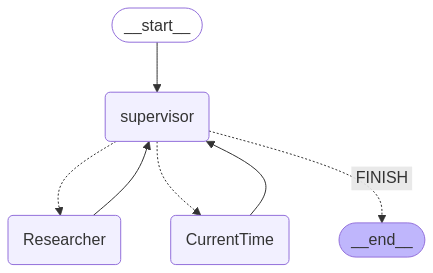

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph.stream({"messages": [HumanMessage(content = "How does photosynthesis work?")]},
                      config={"callbacks": [langfuse_handler], "run_name": "supervisor_202503"}):
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Photosynthesis is a biological process through which organisms like plants, algae, and cyanobacteria convert light energy, typically from sunlight, into chemical energy. This process primarily occurs in these organisms' chloroplasts and is vital for producing and maintaining the oxygen level in the Earth's atmosphere, supplying most of the biological energy needed for complex life.\n\n1. **Light-Dependent Reactions**: These reactions occur when light energy is absorbed by proteins called reaction centers, containing photosynthetic pigments like chlorophylls. In plants, chlorophyll absorbs red and blue light, reflecting green, and is housed in chloroplasts within leaf cells. This process involves splitting water molecules to release oxygen and using the liberated hydrogen to produce two critical molecules: ATP (adenosine triphosphate) and NADPH (reduced nicotinamide adenine dinucleotide phosph